To do

* Description and diagnostics
* Method (diagnostics -> filtering)
* NCI projects
* Conda environment this works with
* References and dependencies
* Compute resources required


In [1]:
import sys
import os
import numpy as np
import xarray as xr

In [2]:
os.environ['WXSYSLIBDIR']='/g/data/ng72/ab4502/WxSysLib' # ⚠️ change to where your WxSysLib is placed
sys.path.append(os.environ['WXSYSLIBDIR'])

#If you have any modules on your system path that contain a "utils" module, these need to be removed
remove_paths = ['/home/548/ab4502/working/sea_breeze'] # ⚠️ change to any sys paths to remove, or leave as an empty string
for path in remove_paths:
    sys.path = np.array(sys.path)[~(np.array(sys.path) == path)].tolist()

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38345,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40973,Total threads: 1
Dashboard: /proxy/40893/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45245,


In [4]:
from utils.diagnostics.sea_breeze import (
sea_breeze_utils,
sea_breeze_filters,
sea_breeze_funcs
)

In [5]:
#Time bounds for a single 6-hour case
t1 = "2016-01-06 06:00"
t2 = "2016-01-06 12:00"

#Lat lon and height bounds (Perth, Australia)
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)
hgt_slice = slice(0,4500)


In [6]:
#Load land sea mask and compute coastline angles



orog, lsm = sea_breeze_utils.load_aus2200_static(
    "mjo-elnino2016",
    lon_slice,
    lat_slice)
angle_ds = sea_breeze_utils.get_coastline_angle(
    lsm,
    R=4,
    latlon_chunk_size=8,
    compute=True,
    smooth=False)

#Angle ds is required 

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in power
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

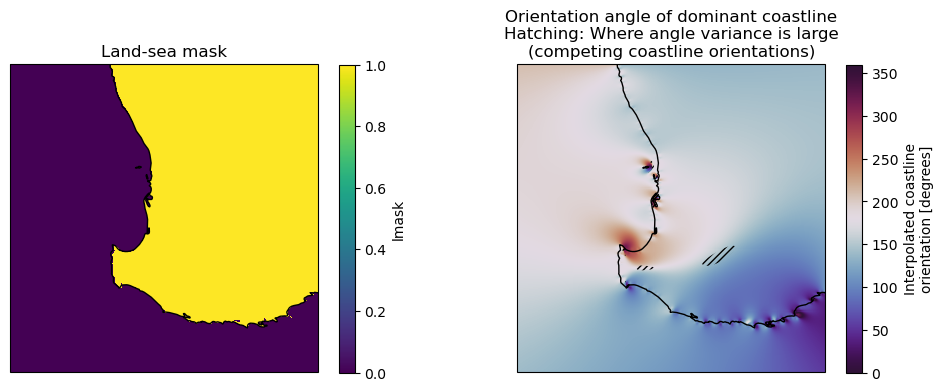

In [8]:
#Plot the model land sea mask and coastline angles

#Needed for SBI and some optional filters

plt.figure(figsize=[12,4])
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
lsm.plot()
ax.coastlines()
plt.title("Land-sea mask")
ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
angle_ds.angle_interp.plot(cmap="twilight_shifted",vmin=0,vmax=360)
xr.plot.contourf(angle_ds.variance_interp,levels=[0.,0.5],hatches=["","/////"],colors="none",add_colorbar=False)
ax.coastlines()
plt.title("Orientation angle of dominant coastline\nHatching: Where angle variance is large\n(competing coastline orientations)");

In [9]:
chunks = {"lev":{},"time":1,"lat":-1,"lon":-1}

#Set smoothing option to True (gaussian smoothing filter with a sigma of 4. See scipy.ndimage.gaussian_filter)
#This will smooth the AUS2200 data including the angle of coastlines
smooth = True
sigma = 4

#Not interpolating heights for simplicity, but should be done normally

#For SBI
#Load V wind
aus2200_va = sea_breeze_utils.round_times(
    sea_breeze_utils.load_aus2200_variable(
        "va",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lat",
        smooth=smooth,
        sigma=sigma,
        hgt_slice=hgt_slice,
        interp_hgts=False),
          "1hr")

#Load U wind
aus2200_ua = sea_breeze_utils.round_times(
    sea_breeze_utils.load_aus2200_variable(
        "ua",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lon",
        smooth=smooth,
        sigma=sigma,
        hgt_slice=hgt_slice,
        interp_hgts=False),
          "1hr")

#Load boundary layer depth
aus2200_zmla = sea_breeze_utils.round_times(
        sea_breeze_utils.load_aus2200_variable(
            "zmla",
            t1,
            t2,
            "mjo-elnino2016",
            lon_slice,
            lat_slice,
            "1hr",
            chunks=chunks,
            staggered="time",
            smooth=smooth,
        sigma=sigma),
              "1hr")

#For frontogenesis

#Load surface V wind
aus2200_vas = sea_breeze_utils.round_times(
    sea_breeze_utils.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lat",
        smooth=smooth,
        sigma=sigma),
          "10min")

#Load surface U wind
aus2200_uas = sea_breeze_utils.round_times(
    sea_breeze_utils.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lon",
        smooth=smooth,
        sigma=sigma),
          "10min")

#Load surface specific humidity
aus2200_hus = sea_breeze_utils.load_aus2200_variable(
        "hus",
        t1,
        t2,
        "mjo-elnino2016",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        smooth=smooth,
        sigma=sigma,
        hgt_slice=slice(0,10)).sel(lev=5)

#Make sure everything is hourly (consistent with ua and va)
aus2200_hus = aus2200_hus.sel(time=aus2200_hus.time.dt.minute==0)
aus2200_vas = aus2200_vas.sel(time=aus2200_vas.time.dt.minute==0)
aus2200_uas = aus2200_uas.sel(time=aus2200_uas.time.dt.minute==0)    

In [10]:
#Sea breeze index
aus2200_wind = xr.Dataset({"u":aus2200_ua,"v":aus2200_va})
sbi = sea_breeze_funcs.calc_sbi(aus2200_wind,
                            angle_ds.angle_interp,
                            subtract_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla,
                            vert_coord="lev")

In [11]:
#Moisture frontogenesis
F = sea_breeze_funcs.kinematic_frontogenesis(
        aus2200_hus,
        aus2200_uas,
        aus2200_vas
    ) 

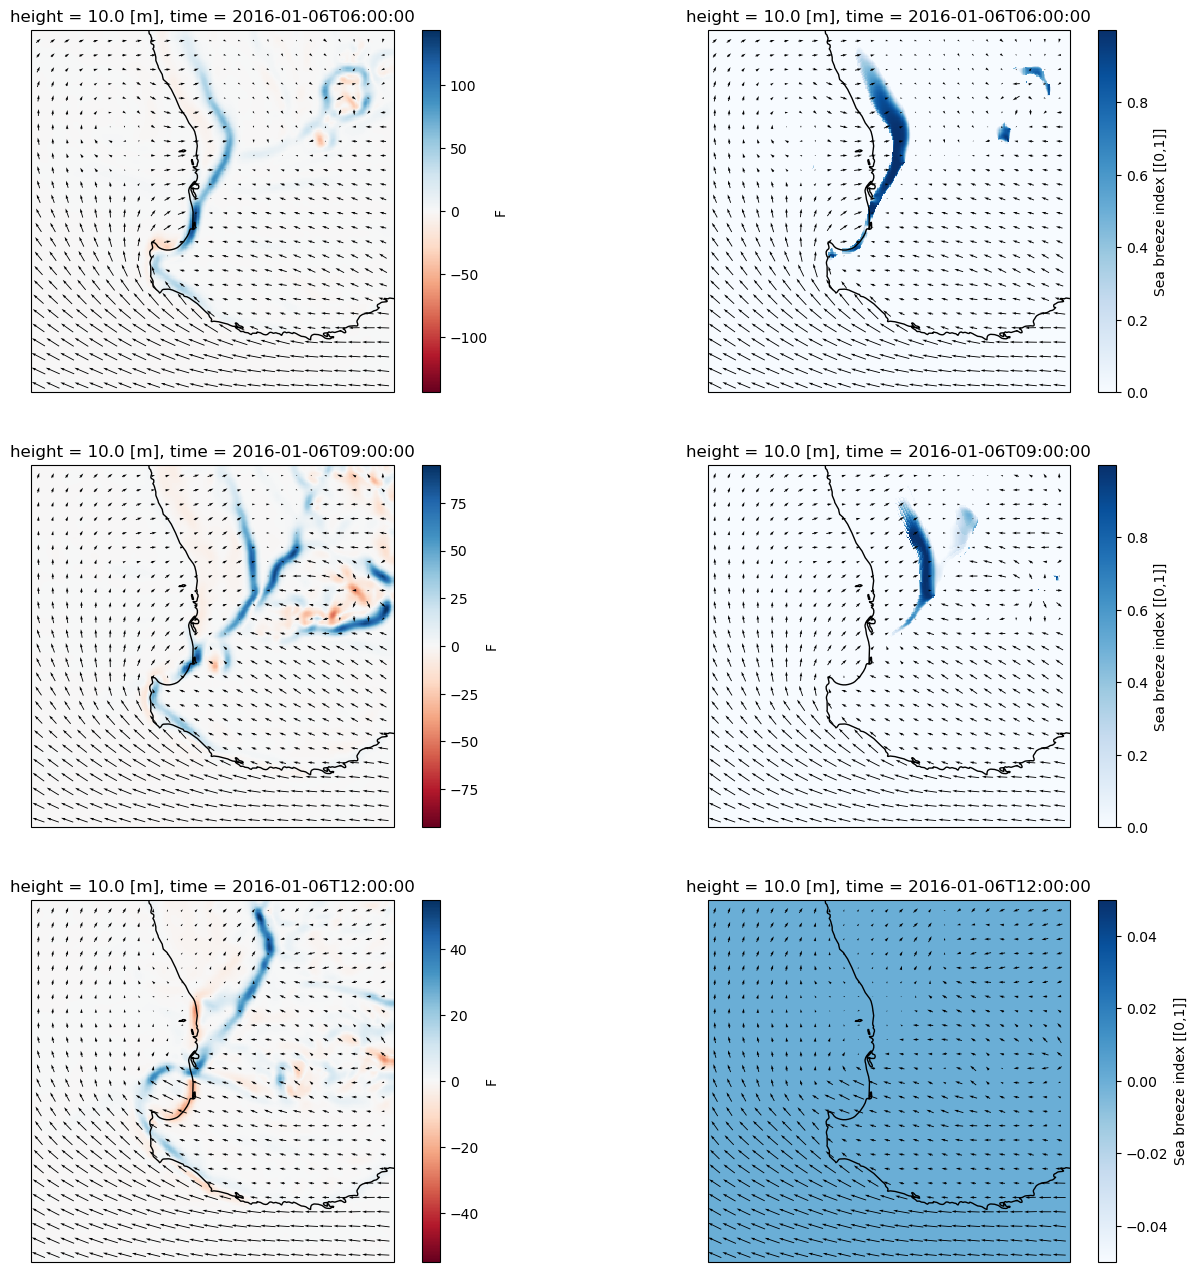

In [19]:
def plot(ds,field,ax,time,u,v,cmap):
    ds[field].sel(time=time).plot(cmap=cmap)
    xr.Dataset({"u":u,"v":v}).sel(time=t).coarsen({"lat":12,"lon":12},boundary="trim").mean().\
        plot.quiver(x="lon",y="lat",u="u",v="v")
    ax.coastlines()

plt.figure(figsize=[16,16])

t = "2016-01-06 06:00"
ax=plt.subplot(3,2,1,projection=ccrs.PlateCarree())
plot(F,"F",ax,t,aus2200_uas,aus2200_vas,cmap="RdBu")
ax=plt.subplot(3,2,2,projection=ccrs.PlateCarree())
plot(sbi,"sbi",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 09:00"
ax=plt.subplot(3,2,3,projection=ccrs.PlateCarree())
plot(F,"F",ax,t,aus2200_uas,aus2200_vas,cmap="RdBu")
ax=plt.subplot(3,2,4,projection=ccrs.PlateCarree())
plot(sbi,"sbi",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 12:00"
ax=plt.subplot(3,2,5,projection=ccrs.PlateCarree())
plot(F,"F",ax,t,aus2200_uas,aus2200_vas,cmap="RdBu")
ax=plt.subplot(3,2,6,projection=ccrs.PlateCarree())
plot(sbi,"sbi",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")

In [20]:
#Set up filtering options. Here just use the orientation and area filters
kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":False,                    
    "temperature_change_filter":False,
    "humidity_change_filter":False,
    "wind_change_filter":False,
    "onshore_wind_filter":False,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    }

#Set the fixed SBI and F thresholds. These represent the 99.5th percentile 
# from AUS2200 data over a 6-month period 
thresh_sbi = 0.41
thresh_F = 18.8

# #For the propagation speed filter, we also need to provide vprime (the onshore wind component)
# uprime, vprime = sea_breeze_utils.rotate_wind(
#     aus2200_uas,
#     aus2200_vas,
#     angle_ds["angle_interp"])

#Do the filtering
F_objects = sea_breeze_filters.filter_3d(
    F.F,
    threshold="fixed",
    threshold_value=thresh_F,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path="out.csv",
    **kwargs)

sbi_objects = sea_breeze_filters.filter_3d(
    sbi.sbi,
    threshold="fixed",
    threshold_value=thresh_sbi,
    lsm=lsm,
    angle_ds=angle_ds,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path="out.csv",
    **kwargs)


/g/data/ng72/ab4502/WxSysLib/utils/diagnostics/sea_breeze/sea_breeze_filters.py:450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props_df["time_utc"] = time


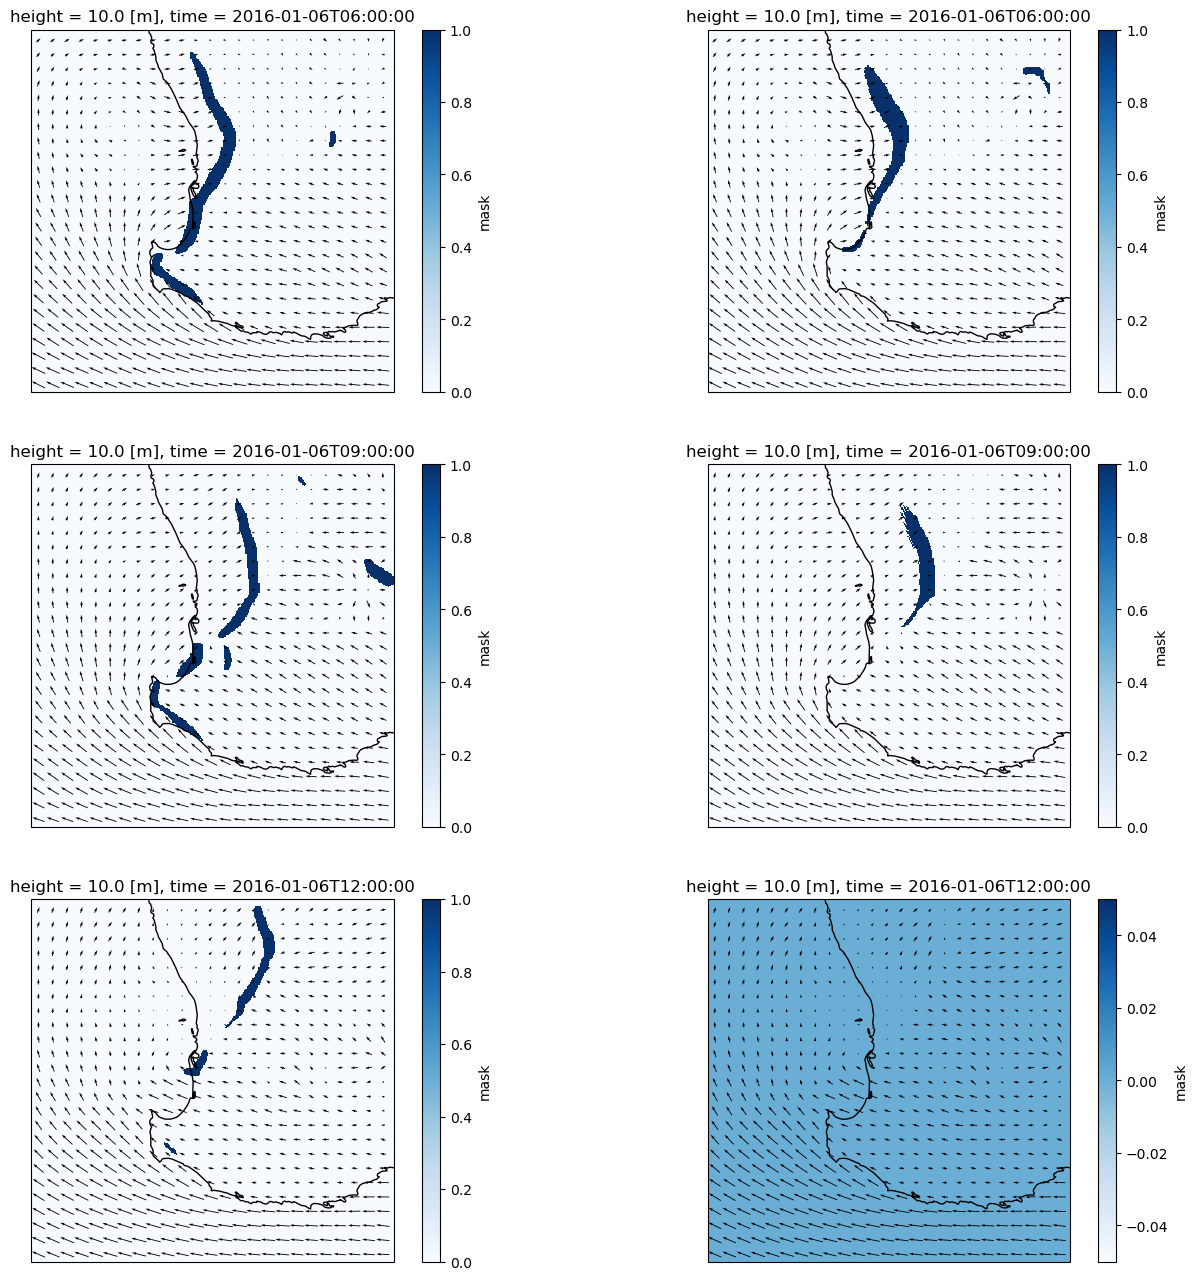

In [21]:
def plot(ds,field,ax,time,u,v,cmap):
    ds[field].sel(time=time).plot(cmap=cmap)
    xr.Dataset({"u":u,"v":v}).sel(time=t).coarsen({"lat":12,"lon":12},boundary="trim").mean().\
        plot.quiver(x="lon",y="lat",u="u",v="v")
    ax.coastlines()

plt.figure(figsize=[16,16])

t = "2016-01-06 06:00"
ax=plt.subplot(3,2,1,projection=ccrs.PlateCarree())
plot(F_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,2,2,projection=ccrs.PlateCarree())
plot(sbi_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 09:00"
ax=plt.subplot(3,2,3,projection=ccrs.PlateCarree())
plot(F_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,2,4,projection=ccrs.PlateCarree())
plot(sbi_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")


t = "2016-01-06 12:00"
ax=plt.subplot(3,2,5,projection=ccrs.PlateCarree())
plot(F_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")
ax=plt.subplot(3,2,6,projection=ccrs.PlateCarree())
plot(sbi_objects,"mask",ax,t,aus2200_uas,aus2200_vas,cmap="Blues")

In [22]:
#Demonstrate other filtering settings (onshore wind filter, humidity change filter)

#Comments on effectiveness of methods and potential errors

#Acknowledgements